In [1]:
import tensorflow as tf
print(tf.__version__)

/anaconda3/envs/dlcv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, shuffle_buffer, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [10]:
train_set = windowed_dataset(series, window_size, shuffle_buffer_size, batch_size=128)


In [ ]:
model = tf.keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=100, verbose=0, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 2s 163ms/step - loss: 12.7807 - mae: 13.3380
Epoch 2/100
12/12 [==============================] - 0s 29ms/step - loss: 12.3969 - mae: 12.8791
Epoch 3/100
12/12 [==============================] - 0s 27ms/step - loss: 11.8293 - mae: 12.2978
Epoch 4/100
12/12 [==============================] - 0s 27ms/step - loss: 11.2978 - mae: 11.7908
Epoch 5/100
12/12 [==============================] - 0s 26ms/step - loss: 10.8785 - mae: 11.3840
Epoch 6/100
12/12 [==============================] - 0s 27ms/step - loss: 10.5960 - mae: 11.0966
Epoch 7/100
12/12 [==============================] - 0s 30ms/step - loss: 10.4010 - mae: 10.8795
Epoch 8/100
12/12 [==============================] - 0s 31ms/step - loss: 10.2628 - mae: 10.7349
Epoch 9/100
12/12 [==============================] - 0s 31ms/step - loss: 10.1233 - mae: 10.6191
Epoch 10/100
12/12 [==============================] - 0s 29ms/step - loss: 10.0309 - mae: 10.5214
Epoch 11/100
12/12 [========

[1e-07, 0.0001, 0, 50]

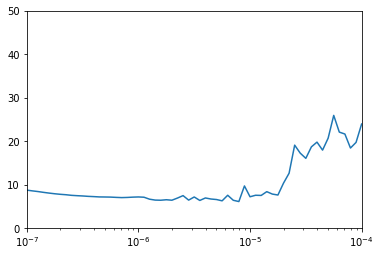

In [14]:
lrs = 1e-8 * (10**(np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 50])

In [25]:
optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, verbose=0, epochs=500)

In [16]:
def forecaster(_model):
    forecast = []

    for time in range(len(series) - window_size):
        forecast.append(_model.predict(series[time:time + window_size][np.newaxis]))
    
    forecast = forecast[split_time - window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results

In [17]:
results = forecaster(model)

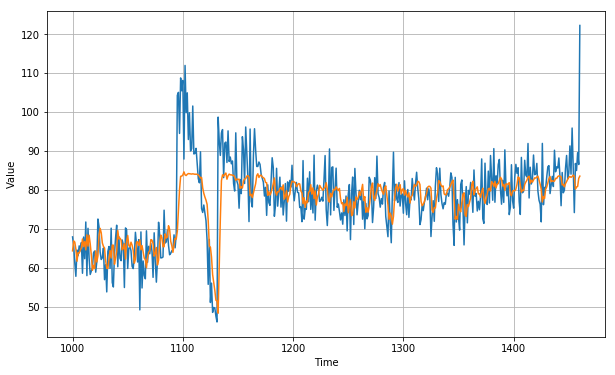

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.261398

In [21]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

/anaconda3/envs/dlcv/lib/python3.6/site-packages/matplotlib/legend.py:936: UserWarning: Legend does not support 'M' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/envs/dlcv/lib/python3.6/site-packages/matplotlib/legend.py:936: UserWarning: Legend does not support 'A' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/envs/dlcv/lib/python3.6/site-packages/matplotlib/legend.py:936: UserWarning: Legend does not support 'E' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


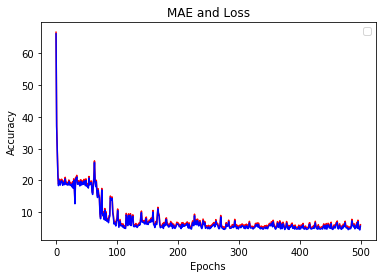

In [22]:
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend("MAE", "Loss")
plt.figure()

In [23]:
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

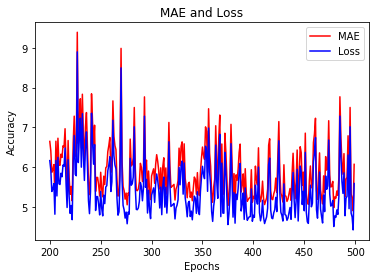

In [24]:
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(["MAE", "Loss"])
plt.figure()